In [8]:
import time
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# Mackey-Glass series computation
def mackey(n_iters):
    x = np.zeros((n_iters,))
    x[0:30] = 0.23 * np.ones((30,))
    t_s = 30
    for i in range(30, n_iters - 1):
        a = x[i]
        b = x[i - t_s]
        y = ((0.2 * b) / (1 + b ** 10)) + 0.9 * a
        x[i + 1] = y
    return x

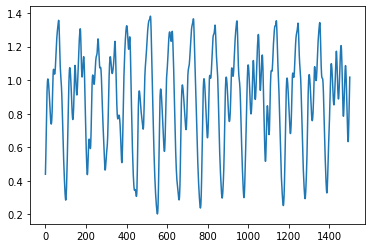

In [107]:
N = 2000  # Number of points to generate
mg_series = mackey(N)[499:]  # Use last 1500 points
plt.plot(mg_series)
plt.show()

In [108]:
class ANFIS:
    def __init__(self, n_inpts, n_rules):
        self.n = n = n_inpts
        self.m = m = n_rules
        self.mus = np.zeros(shape=(1, n * m))
        self.sigmas = np.zeros(shape=(1, n * m))
        self.y = np.zeros(shape=(1, m))

    def setmfs(self, means, stdevs, sequents):
        self.mus = means
        self.sigmas = stdevs
        self.y = sequents

    def rule_firing(self, x):
        # Evaluates membership functions on each input for the whole batch
        F = np.reshape(np.exp(-0.5 * ((np.tile(x, (1, self.m)) - self.mus) ** 2) / (self.sigmas ** 2)),
                       (-1, self.m, self.n))
        # Gets the firing strenght of each rule by applying T-norm (product in this case)
        return np.prod(F, axis=2)

    def defuzzify(self, w):
        return np.sum(self.y * w, axis=1) / np.clip(np.sum(w, axis=1), a_min=1e-12, a_max=1e12)

    def infer(self, x):
        return self.defuzzify(self.rule_firing(x))

    def plotmfs(self):
        mus = np.reshape(self.mus, (self.m, self.n))
        sigmas = np.reshape(self.sigmas, (self.m, self.n))
        xn = np.linspace(np.min(mus) - 3 * np.max(sigmas), np.max(mus) + 3 * np.max(sigmas), 1000)
        for r in range(self.m):
            if r % 4 == 0:
                plt.figure(figsize=(11, 6), dpi=80)
            plt.subplot(2, 2, (r % 4) + 1)
            ax = plt.subplot(2, 2, (r % 4) + 1)
            ax.set_title("Rule %d, sequent center: %f" % ((r + 1), self.y[r]))
            for i in range(self.n):
                plt.plot(xn, np.exp(-0.5 * ((xn - mus[r, i]) ** 2) / (sigmas[r, i] ** 2)))

In [109]:
def differential_evolution(fobj, bounds, mut=0.8, crossprob=0.7, popsize=30, gens=1000, mode='best/1'):
    # Gets number of parameters (length of genome vector)
    num_params = len(bounds)
    # Initializes the population genomes with values drawn from uniform distribution in the range [0,1]
    pop = np.random.rand(popsize, num_params)
    # Gets the boundaries for each parameter to scale the population genomes
    min_b, max_b = np.asarray(bounds).T
    # Scales the population genomes from the range [0,1] to the range specified by the parameter boundaries
    diff = np.fabs(min_b - max_b)
    pop_scaled = min_b + pop * diff
    # Evaluates fitness for each individual in the population by calculating the objective to minimize
    unfitness = np.asarray([fobj(ind) for ind in pop_scaled])
    # Gets the best individual of the population
    best_idx = np.argmin(unfitness)
    best = pop_scaled[best_idx]
    for i in range(gens):
        print('Best unfitness in generation %d: %f' % (i + 1, unfitness[best_idx]))
        # For each individual:
        for j in range(popsize):
            # Selects three individuals from the population different than himself(no jerking off) for reproduction
            if mode == 'best/1':
                idxs = [idx for idx in range(popsize) if (idx != j and idx != best_idx)]
                a = best
                b, c = pop[np.random.choice(idxs, 2, replace=False)]
                mutant = np.clip(a + mut * (b - c), 0, 1)
            elif mode == 'best/2':
                idxs = [idx for idx in range(popsize) if (idx != j and idx != best_idx)]
                a = best
                b, c, d, e = pop[np.random.choice(idxs, 4, replace=False)]
                # Generates a mutant by applying the differential mutation (and clips to keep in range [0,1])
                mutant = np.clip(a + mut * (b - c + d - e), 0, 1)
            elif mode == 'rand/1':
                idxs = [idx for idx in range(popsize) if idx != j]
                a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
                # Generates a mutant by applying the differential mutation (and clips to keep in range [0,1])
                mutant = np.clip(a + mut * (b - c), 0, 1)
            elif mode == 'rand/2':
                idxs = [idx for idx in range(popsize) if idx != j]
                a, b, c, d, e = pop[np.random.choice(idxs, 5, replace=False)]
                # Generates a mutant by applying the differential mutation (and clips to keep in range [0,1])
                mutant = np.clip(a + mut * (b - c + d - e), 0, 1)
            # Selects parameters of the individual to crossover with the mutant with the probability of crossover
            cross_points = np.random.rand(num_params) < crossprob
            # If some parameter results to need crossover ...
            if not np.any(cross_points):
                # selects the index of that parameter for crossover
                cross_points[np.random.randint(0, num_params)] = True
            # The parameters of the individual's genome that require crossover gets changed for those of the mutant,
            # producing a new individual
            trial = np.where(cross_points, mutant, pop[j])
            # Scales the genome of the new individual from the range [0,1] to the range specified by the parameter
            # boundaries
            trial_denorm = min_b + trial * diff
            # Evaluates fitness of new individual
            f = fobj(trial_denorm)
            # If better than the previous one, keeps the new one
            if f < unfitness[j]:
                unfitness[j] = f
                pop[j] = trial
                # If better than the best one so far, updates the record
                if f < unfitness[best_idx]:
                    best_idx = j
                    best = trial_denorm
        yield best, unfitness[best_idx]

In [110]:
# Evaluates the objective function
def eval_objective(params):
    # From the parameter vector (genome) gets each set of parameters (means, standard deviations and sequent singletons)
    mus = params[0:fis.m * fis.n]
    sigmas = params[fis.m * fis.n:2 * fis.m * fis.n]
    y = params[2 * fis.m * fis.n:]
    # Sets the FIS parameters to the ones on the genome
    fis.setmfs(mus, sigmas, y)
    pred = fis.infer(data)
    loss = 1 - nse(pred, lbls)
    return loss

# Root Mean Square Error
def rmse(pred, real):
    return np.sqrt(np.mean((pred - real) ** 2))


# Mean Absolute Difference
def abs_diff(pred, real):
    return np.mean(np.abs(pred - real))


# Pearson correlation coefficient
def corrcoeff(pred, real):
    pcorr = (np.sum(pred * real) - pred.size * np.mean(pred) * np.mean(real)) / (
                (pred.size - 1) * np.std(pred) * np.std(real))
    return pcorr


# Prediction of Change in Direction
def pocid(pred, real):
    d = np.diff(real)
    dp = np.diff(pred)
    return np.mean(np.sign(d) == np.sign(dp))


# Nash-Sutcliffe Efficiency Index
def nse(pred, real):
    return 1 - (np.sum((real - pred) ** 2)) / (np.sum((real - np.mean(real)) ** 2))


# Mean Absolute Error
def mae(pred, real):
    return np.mean(np.abs((real - pred) / real))


# Entropy
def entropy(p, q):
    return -np.sum(p * np.log(q.clip(1e-12, None)))


# Cross-entropy
def ce(pred, real):
    f_real, intervals = np.histogram(real, bins=len(np.unique(real))-1)
    intervals[0] = min(min(pred), min(real))
    intervals[-1] = max(max(pred), max(real))
    f_real = f_real / real.size
    f_pred = np.histogram(pred, bins=intervals)[0] / pred.size
    return entropy(f_real, f_pred)


# Kullback-Leibler divergence
def kldiv(pred, real):
    f_real, intervals = np.histogram(real, bins=len(np.unique(real))-1)
    intervals[0] = min(min(pred), min(real))
    intervals[-1] = max(max(pred), max(real))
    f_real = f_real / real.size
    f_pred = np.histogram(pred, bins=intervals)[0] / pred.size
    # kl = entropy(f_pred, f_real) - entropy(f_pred, f_pred)
    kl = entropy(f_real, f_pred) - entropy(f_real, f_real)
    return kl

Best unfitness in generation 1: 0.225086
Best unfitness in generation 2: 0.225086
Best unfitness in generation 3: 0.225086
Best unfitness in generation 4: 0.225086
Best unfitness in generation 5: 0.225086
Best unfitness in generation 6: 0.225086
Best unfitness in generation 7: 0.221443
Best unfitness in generation 8: 0.048234
Best unfitness in generation 9: 0.048234
Best unfitness in generation 10: 0.048234
Evolution time: 1.413891


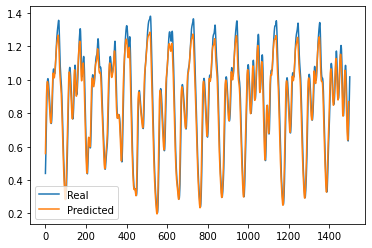

In [111]:
# Generate dataset
D = 4  # number of regressors
T = 1  # delay
data = np.zeros((N - 500 - T - (D - 1) * T, D))
lbls = np.zeros((N - 500 - T - (D - 1) * T,))

for t in range((D - 1) * T, N - 500 - T):
    data[t - (D - 1) * T, :] = [mg_series[t - 3 * T], mg_series[t - 2 * T], mg_series[t - T], mg_series[t]]
    lbls[t - (D - 1) * T] = mg_series[t + T]

# Creates the inference system
m = 16  # number of rules
fis = ANFIS(D, m)
n_params = 2 * (m * D) + m  # Total number of parameters (genome size)

# Runs the evolution cycle
start_time = time.time()
result = list(differential_evolution(eval_objective, bounds=[(-2, 2)] * n_params, gens=10))
end_time = time.time()
print('Evolution time: %f' % (end_time - start_time))
# Gets the last genome
best_params = result[-1][0]
best_mus = best_params[0:fis.m * fis.n]
best_sigmas = best_params[fis.m * fis.n:2 * fis.m * fis.n]
best_y = best_params[2 * fis.m * fis.n:2 * fis.m * fis.n + fis.m]
# Sets the FIS parameters to the ones of the last genome
fis.setmfs(best_mus, best_sigmas, best_y)
# Predicts output for the training set
best_pred = fis.infer(data)
# Plots the real and predicted one series
plt.plot(mg_series)
plt.plot(best_pred)
plt.legend(['Real', 'Predicted'])
plt.show()